In [4]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import pandas as pd

In [8]:
#cat= pd.read_csv('/home/kei/Escritorio/cats/LAE_catalog_SHELA_P12_rg-n419_SE_2024_09_19_expanded.csv')
cat= pd.read_csv('https://raw.githubusercontent.com/keiclouds/LAE_COD/refs/heads/main/LAE_catalog_SHELA_P12_rg-n419_SE_2024_09_19_expanded.csv')

In [ ]:
#import gdown
#gdown.download(id="1IfO2698pXm9RO_9gEpdhZd343OiW8Xtp", output="SHELA_P12_N419_allband_merged_cat_feb2024.fits", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1IfO2698pXm9RO_9gEpdhZd343OiW8Xtp
From (redirected): https://drive.google.com/uc?id=1IfO2698pXm9RO_9gEpdhZd343OiW8Xtp&confirm=t&uuid=15cf4086-594d-4643-803d-fde62270b9f0
To: /workspaces/LAE_COD/SHELA_P12_N419_allband_merged_cat_feb2024.fits
100%|██████████| 848M/848M [00:10<00:00, 81.7MB/s] 


'SHELA_P12_N419_allband_merged_cat_feb2024.fits'

In [19]:
#file = '/home/kei/Escritorio/cats/SHELA_P12_N419_allband_merged_cat_feb2024.fits'
file = '/workspaces/LAE_COD/SHELA_P12_N419_allband_merged_cat_feb2024.fits'
hdul = fits.open(file)
tabla = Table(hdul['LDAC_OBJECTS'].data)

In [20]:
# Extraer MAG_APER y MAGERR_APER, y quedarnos con la columna 3, las cuales corresponden a N419 (índice 3)
tabla['MAG_APER_3'] = np.array(tabla['MAG_APER'].tolist())[:, 3]
tabla['MAGERR_APER_3'] = np.array(tabla['MAGERR_APER'].tolist())[:, 3]
tabla['FLUX_RADIUS_3'] = np.array(tabla['FLUX_RADIUS'].tolist())[:, 2]
tabla['FLUX_APER_3']= np.array(tabla['FLUX_APER'].tolist())[:, 3]
tabla['FLUXERR_APER_3']= np.array(tabla['FLUXERR_APER'].tolist())[:, 3]
tabla['FLUX_APER_G_3']= np.array(tabla['FLUX_APER_G'].tolist())[:, 3]
tabla['FLUXERR_APER_G_3']= np.array(tabla['FLUXERR_APER_G'].tolist())[:, 3]
tabla['FLUX_APER_R_3']= np.array(tabla['FLUX_APER_R'].tolist())[:, 3]
tabla['FLUXERR_APER_R_3']= np.array(tabla['FLUXERR_APER_R'].tolist())[:, 3]

In [21]:
# Filtrar solo columnas de una dimensión para pasar a pandas
colfilt = [col for col in tabla.colnames if len(tabla[col].shape) <= 1]
tabla = tabla[colfilt]


In [22]:
# Columnas necesarias para análisis
cols_necesarias = [
    'NUMBER', 'X_WORLD', 'Y_WORLD',
    'MAG_AUTO_G', 'MAGERR_AUTO_G', 'MAG_AUTO_R', 'MAGERR_AUTO_R',
    'MAG_APER_3', 'MAGERR_APER_3','FLUX_APER_3','FLUXERR_APER_3', 'FLUX_APER_G_3','FLUXERR_APER_G_3','FLUX_APER_R_3','FLUXERR_APER_R_3',
    'FLUX_AUTO_G', 'FLUXERR_AUTO_G', 'FLUX_AUTO_R', 'FLUXERR_AUTO_R',
    'IMAFLAGS_ISO', 'FLAGS', 'CLASS_STAR',
    'ELLIPTICITY', 'KRON_RADIUS', 'FWHM_WORLD', 'FLUX_RADIUS_3'
]

df = tabla[cols_necesarias].to_pandas()
print("Total de filas antes del modelo híbrido:", len(df))


Total de filas antes del modelo híbrido: 431525


In [23]:
# --- Aplicar cortes de calidad ---
# 1. FLUX ≠ 0 y MAGERR_APER ≠ 0
df['cond1'] = (df['FLUX_APER_G_3'] != 0)
df['cond2'] = (df['FLUX_APER_R_3'] != 0)
df['cond3'] = (df['FLUXERR_APER_3'] != 0)

# 2. S/N > 5 para MAG_APER_3
df['cond4'] = (df['FLUX_APER_3'] / df['FLUXERR_APER_3']) >= 5.

# 3. IMAFLAGS_ISO = 0
df['cond5'] = (df['IMAFLAGS_ISO'] == 0.0)

# 4. FLAGS < 4
df['cond6'] = (df['FLAGS'] < 4.0)

# Revisar cuántas cumplen cada condición
for i in range(1, 7):
    print(f'Condición {i}:')
    print(df[f'cond{i}'].value_counts(), '\n')

Condición 1:
cond1
True     431162
False       363
Name: count, dtype: int64 

Condición 2:
cond2
True     431210
False       315
Name: count, dtype: int64 

Condición 3:
cond3
True    431525
Name: count, dtype: int64 

Condición 4:
cond4
True     412479
False     19046
Name: count, dtype: int64 

Condición 5:
cond5
True     428826
False      2699
Name: count, dtype: int64 

Condición 6:
cond6
True     430301
False      1224
Name: count, dtype: int64 



In [24]:
calidad=df[[f'cond{i}' for i in range(1, 7)]].all(axis=1)
print(f'Número final de objetos tras cortes: {len(calidad)}')


Número final de objetos tras cortes: 431525


In [25]:
# Parámetro w419 según Firestone (Tabla 2)
w419 = -0.438 

In [27]:
#calculo SN
import numpy as np

# Calcular S/N para bandas G y R
df['SN_G'] = df['FLUX_APER_G_3'] / df['FLUXERR_APER_G_3']
df['SN_R'] = df['FLUX_APER_R_3'] / df['FLUXERR_APER_R_3']

# Crear máscaras según el S/N
grupo_mag = (df['SN_G'] >= 3) & (df['SN_R'] >= 3)
grupo_flux = ~grupo_mag  # los que tienen S/N < 3 en al menos una banda

# Inicializar columnas
df['rg_mag'] = np.nan
df['rg_err'] = np.nan
df['rg_flux'] = np.nan  # solo se usará para el grupo de flujos

# --- Grupo 1: usar modelo de magnitudes estimadas desde flujo ---
# Convertir FLUX_APER a magnitud sin constante adicional
mag_r = -2.5 * np.log10(df['FLUX_APER_R_3'])
mag_g = -2.5 * np.log10(df['FLUX_APER_G_3'])

# Errores de magnitud (sin constante)
err_r = (2.5 / np.log(10)) * (df['FLUXERR_APER_R_3'] / df['FLUX_APER_R_3'])
err_g = (2.5 / np.log(10)) * (df['FLUXERR_APER_G_3'] / df['FLUX_APER_G_3'])

# Aplicar interpolación en magnitudes
df.loc[grupo_mag, 'rg_mag'] = w419 * mag_r[grupo_mag] + (1 - w419) * mag_g[grupo_mag]
df.loc[grupo_mag, 'rg_err'] = np.sqrt((w419 * err_r[grupo_mag])**2 + ((1 - w419) * err_g[grupo_mag])**2)

# --- Grupo 2: usar modelo de flujos directamente ---
df.loc[grupo_flux, 'rg_flux'] = (
    w419 * df.loc[grupo_flux, 'FLUX_APER_R_3'] + (1 - w419) * df.loc[grupo_flux, 'FLUX_APER_G_3']
)

# Eliminar entradas no válidas (nan o flujo negativo)
grupo_flux_valid = grupo_flux & (df['rg_flux'] > 0)

df.loc[grupo_flux_valid, 'rg_mag'] = -2.5 * np.log10(df.loc[grupo_flux_valid, 'rg_flux'])

# Error asociado
df.loc[grupo_flux_valid, 'rg_err'] = (
    (2.5 / np.log(10)) *
    (np.sqrt(
        (w419 * df.loc[grupo_flux_valid, 'FLUXERR_APER_R_3'])**2 +
        ((1 - w419) * df.loc[grupo_flux_valid, 'FLUXERR_APER_G_3'])**2
    ) / df.loc[grupo_flux_valid, 'rg_flux'])
)


/home/codespace/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [28]:
from astropy.io import ascii
t419txt= ascii.read('https://raw.githubusercontent.com/keiclouds/LAE_COD/refs/heads/main/N419_simulated_transmission_f3.6.txt')
t419 = t419txt.to_pandas()
#cargamos la data de las broadbans g,r,i,z,Y:

#BBtxt = ascii.read('/Users/pauly/Downloads/broadbands.txt')
BBtxt = ascii.read('https://raw.githubusercontent.com/keiclouds/LAE_COD/refs/heads/main/broadbands.txt')
#conversion de la "tabla" a un DataFrame de Pandas para poder utilizar función apply
BB = BBtxt.to_pandas()

#LAMBDA estaba en angstrom y los filtros son adiminesionales 
BB['wave'] = BB['LAMBDA']*(0.1)

#BB['gr'] = BB.apply(lambda row: w * row['g'] + (1 - w) * row['r'], axis=1)  # Transmisión

BB['rg'] = BB.apply(lambda row: w419 * row['r'] + (1 - w419) * row['g'], axis=1)  # Transmisión

#BB

In [29]:
import scipy.integrate as integrate
from scipy.integrate import quad
def integrand(x, c, T_BB):
    return (c * T_BB) / (x**2)

a, b = 400, 480
c = 3 * 10**14
integrals_quad = []
errors_quad = []

for index, row in BB.iterrows():
    integral, error = quad(integrand, a, b, args=(c, row['rg']))
    integrals_quad.append(integral)
    errors_quad.append(error)
    
BB['area'] = integrals_quad
BB['error'] = errors_quad
area_rg = BB['area'].sum()
total_error_rg = np.sqrt(np.sum(np.array(errors_quad)**2))
print("El área total bajo la curva es:", area_rg)
print("El error total estimado es:", total_error_rg)

El área total bajo la curva es: 14738244942500.0
El error total estimado es: 0.01978580496120696


In [30]:
wave = t419['Wavelength[nm]']
T = t419['Transmission']

def integrand(x, c, T):
    return (c * T) / (x**2)

a, b = 400, 480
c = 3 * 10**14
integrals_quad = []
errors_quad = []

for index, row in t419.iterrows():
    integral, error = quad(integrand, a, b, args=(c, row['Transmission']))
    integrals_quad.append(integral)
    errors_quad.append(error)
    
t419['area'] = integrals_quad
t419['error'] = errors_quad
area_n419 = t419['area'].sum()
total_error_n419 = np.sqrt(np.sum(np.array(errors_quad)**2))
print("El área total bajo la curva es:", area_n419)
print("El error total estimado es:", total_error_n419)

El área total bajo la curva es: 4584035245000.0
El error total estimado es: 0.0076973615891856376


In [31]:
C = area_n419 / area_rg
C

np.float64(0.31102992675750885)

In [32]:
# Condición 1: exceso de banda estrecha mínimo
# Usar 'rg_mag' calculado en lugar de 'MAG_APER_3'
df['condition1'] = (df['rg_mag'] - (-2.5 * np.log10(df['FLUX_APER_3']))) >= 0.71

# Condición 2: exceso mayor que 3σ
# Usar 'rg_err' calculado en lugar de 'MAGERR_APER_3'
df['sigma_err'] = np.sqrt(df['rg_err']**2 + (2.5 / np.log(10)) * (df['FLUXERR_APER_3'] / df['FLUX_APER_3'])**2)
df['condition2'] = (df['rg_mag'] - (-2.5 * np.log10(df['FLUX_APER_3']))) >= (3 * df['sigma_err'])

# Condición 3: brillo comparable a una línea de emisión pura
df['condition3'] = (df['rg_mag'] - (-2.5 * np.log10(df['FLUX_APER_3']))) < (-2.5 * np.log10(C) + 2 * df['sigma_err'])

# Condición 4: radio efectivo menor que 1.38 arcsec
pixel_scale = 0.168  # arcsec/pixel (valor común para HSC)

# Convertir R50 de pix a arcsec
df['FLUX_RADIUS_3_ARC'] = df['FLUX_RADIUS_3'] * pixel_scale

# Aplicar la condición 4: R50 < 1.38 arcsec
df['condition4'] = df['FLUX_RADIUS_3_ARC'] < 1.38

# Condición 5: magnitud en banda estrecha mayor o igual a 20
# Usar 'rg_mag' calculado en lugar de 'MAG_APER_3'
df['condition5'] = df['rg_mag'] >= 20

# Condición 6: magnitud en banda estrecha menor que el límite 5σ (25.5 para N419)
df['condition6'] = df['rg_mag'] < 25.5

# Imprimir conteos
for cond in ['condition1', 'condition2', 'condition3', 'condition4', 'condition5', 'condition6']:
    print(f'{cond}:')
    print(df[cond].value_counts(), '\n')


condition1:
condition1
False    420488
True      11037
Name: count, dtype: int64 

condition2:
condition2
False    400967
True      30558
Name: count, dtype: int64 

condition3:
condition3
True     424874
False      6651
Name: count, dtype: int64 

condition4:
condition4
True     395697
False     35828
Name: count, dtype: int64 

condition5:
condition5
True     420644
False     10881
Name: count, dtype: int64 

condition6:
condition6
True     383246
False     48279
Name: count, dtype: int64 



/home/codespace/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/codespace/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [33]:
# Combinar todos los cortes y condiciones
cortes_calidad = df[[f'cond{i}' for i in range(1, 7)]].all(axis=1)
#cortes_magnitud = df[['cortegmax', 'corteerg', 'corteg99', 'cortermax', 'corteerr', 'corter99']].all(axis=1)
condiciones_seleccion = df[[f'condition{i}' for i in range(1, 7)]].all(axis=1)

# Seleccionar solo los que cumplen todo
#selection_1 = df[cortes_calidad & cortes_magnitud & condiciones_seleccion]
selection_1 = df[cortes_calidad & condiciones_seleccion]
# Ver cuántos hay
print(f'Total de candidatos LAEs seleccionados: {len(selection_1)}')


Total de candidatos LAEs seleccionados: 733


In [34]:
# Normalizar a tipo entero, por si acaso
selection_ra = set(selection_1['X_WORLD'].astype(int))
cat_ra = set(cat['RA'].astype(int))

# Intersección
common_ra = selection_ra.intersection(cat_ra)

print(f'Número de coincidencias exactas por RA: {len(common_ra)}')


Número de coincidencias exactas por RA: 4


In [35]:
# Normalizar a tipo entero, por si acaso
selection_ids = set(selection_1['NUMBER'].astype(int))
cat_ids = set(cat['index'].astype(int))

# Intersección
common_ids = selection_ids.intersection(cat_ids)

print(f'Número de coincidencias exactas por ID: {len(common_ids)}')


Número de coincidencias exactas por ID: 4


In [36]:
print(cat.columns)

Index(['index', 'RA', 'DEC', 'n419 flux (ujy)', 'n419 flux err (ujy)',
       'rg flux (ujy)', 'rg flux err (ujy)', 'g flux (ujy)',
       'g flux err (ujy)', 'r flux (ujy)', 'r flux err (ujy)', 'i flux (ujy)',
       'i flux err (ujy)', 'z flux (ujy)', 'z flux err (ujy)',
       'n501 flux (ujy)', 'n501 flux err (ujy)', 'estimated line flux (cgs)',
       'estimated EW_rf (A)', 'estimated EW_rf error (A)'],
      dtype='object')


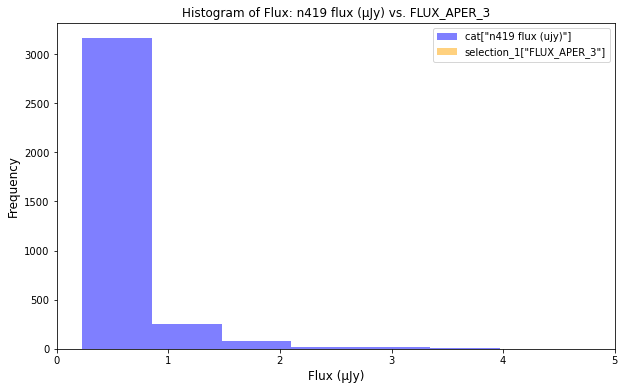

In [67]:
import matplotlib.pyplot as plt

# Crear el histograma para 'n419 flux (ujy)' y 'FLUX_APER_3'
plt.figure(figsize=(10, 6))

# Histograma para 'n419 flux (ujy)'
plt.hist(cat['n419 flux (ujy)'], bins=30, alpha=0.5, label='cat["n419 flux (ujy)"]', color='blue')

# Histograma para 'FLUX_APER_3'
plt.hist(selection_1['FLUX_APER_3'], bins=30, alpha=0.5, label='selection_1["FLUX_APER_3"]', color='orange')
plt.xlim(0,5.)
# Añadir etiquetas y leyenda
plt.xlabel('Flux (µJy)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()

# Mostrar el gráfico
plt.title('Histogram of Flux: n419 flux (µJy) vs. FLUX_APER_3')
plt.show()
